In [1]:
import kagglehub
data_path = kagglehub.dataset_download("naveedhn/amazon-product-review-spam-and-non-spam")
print(data_path)

C:\Users\Aybars\.cache\kagglehub\datasets\naveedhn\amazon-product-review-spam-and-non-spam\versions\1


In [ ]:
import pandas as pd
import re # for regular expression
import nltk 
# detects unnecessary words like "the, a, is, in"
from nltk.corpus import stopwords
# detects roots of words
from nltk.stem import WordNetLemmatizer
import time
import os
import numpy as np

try:
  stop_words = set(stopwords.words("english"))
except LookupError:
  nltk.download("stopwords")
  nltk.download("wordnet")
  nltk.download('omw-1.4')
  stop_words = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()

def clean_text(text):
  if not isinstance(text, str):
    return "";
  text = text.lower()
  text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.I|re.A)
  tokens = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return " ".join(tokens)

def parse_helpful(x):
  if isinstance(x, list) and len(x) == 2:
    return x[0], x[1]
  return 0, 0

In [ ]:
FILE_PATH = os.path.join(data_path, "Toys_and_Games", "Toys_and_Games.json")

chunk_size = 1000000

processed_chunks = []

start_time = time.time()

iterator = pd.read_json(FILE_PATH, lines = True, chunksize = chunk_size)

base_path = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_path, "data", "processed", "Toys_and_Games")
file_name = "toys_and_games.parquet"
full_path = os.path.join(out_dir, file_name)

if (os.path.exists(full_path)):
  print("File already exists")
else:
  print("Reading starts")

  for i, chunk in enumerate(iterator):
    print(f"Part {i} processing...")

    chunk = chunk.copy() 

    helpful_data = chunk['helpful'].apply(parse_helpful)

    chunk["helpful_votes"] = helpful_data.apply(lambda x : x[0])
    chunk["total_votes"] = helpful_data.apply(lambda x : x[1])
    chunk["helpfulness_ratio"] = chunk['helpfulness_ratio'] = np.where(
    chunk['total_votes'] > 0, # Koşul
    chunk['helpful_votes'] / chunk['total_votes'], # Koşul doğruysa yapılacak işlem
    0 # Koşul yanlışsa atanacak değer
)

    chunk["full_text"] = chunk["summary"].astype(str) + " " + chunk["reviewText"].astype(str)
    chunk['cleaned_text'] = chunk['full_text'].apply(clean_text)

    final_chunk = chunk[["cleaned_text", "overall", "helpfulness_ratio", "class"]].copy()

    final_chunk.dropna(subset=['class'], inplace=True)
    # TODO
    final_chunk['class'] = final_chunk['class'].astype(int)

    processed_chunks.append(final_chunk)

  print("Processing completed")

  df = pd.concat(processed_chunks, ignore_index=True)

  end_time = time.time()

  print(f"Duration {end_time - start_time}")
  print(f"Total of {len(df)} lines processed")
  
  print("Saving data...")

  os.makedirs(out_dir, exist_ok=True)
  df.to_parquet(full_path)

  print("Data saved")

File already exists


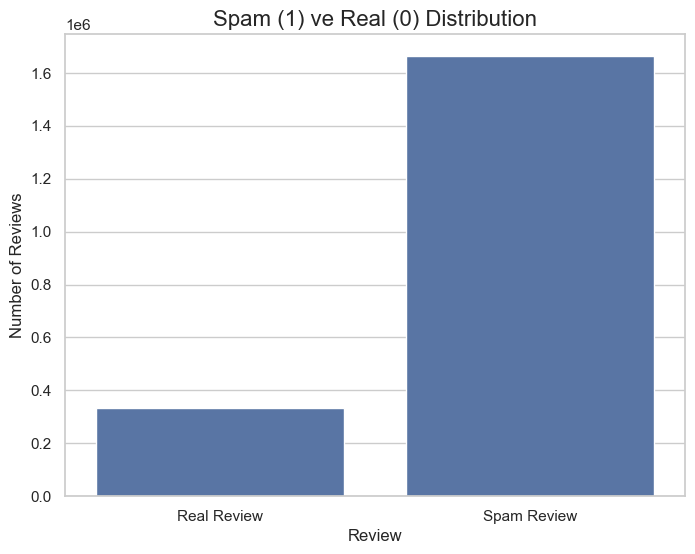

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

data = pd.read_parquet(full_path)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Spam (1) ve Real (0) Distribution', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['Real Review', 'Spam Review'])
plt.show()

C:\Users\Aybars\AppData\Local\Temp\ipykernel_21676\3284485370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=data, palette='viridis')


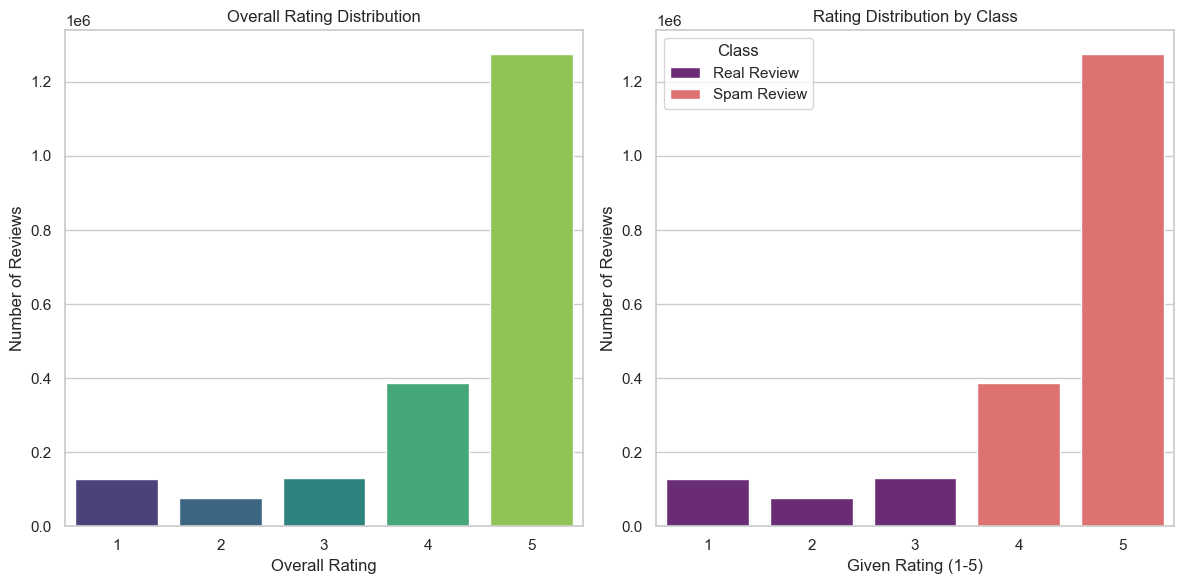

In [5]:
plt.figure(figsize=(12, 6))

# Rating distribution for all data
plt.subplot(1, 2, 1)  # 1 row, 2 columns — first plot
sns.countplot(x='overall', data=data, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

# Rating distribution by class
plt.subplot(1, 2, 2)  # 1 row, 2 columns — second plot
sns.countplot(x='overall', hue='class', data=data, palette='magma')
plt.title('Rating Distribution by Class')
plt.xlabel('Given Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.legend(title='Class', labels=['Real Review', 'Spam Review'])

plt.tight_layout()  # Adjust spacing between plots
plt.show()


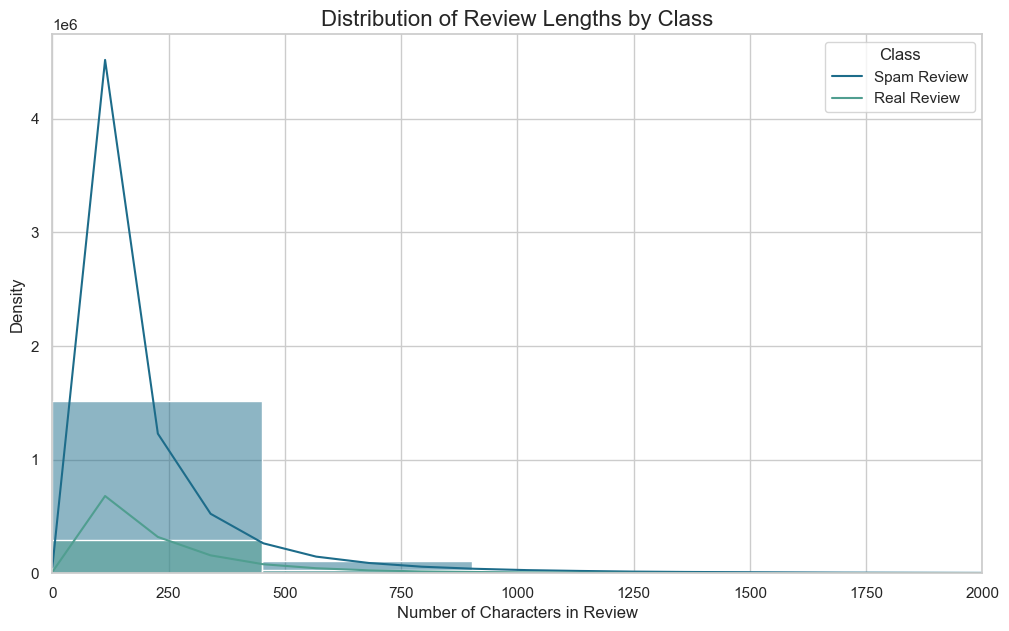

In [6]:
# Calculate the character length of the cleaned texts
data['text_length'] = data['cleaned_text'].str.len()

plt.figure(figsize=(12, 7))
sns.histplot(data=data, x='text_length', hue='class', kde=True, bins=50, palette='crest')
plt.title('Distribution of Review Lengths by Class', fontsize=16)
plt.xlabel('Number of Characters in Review', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Limit the x-axis to prevent very long reviews from distorting the plot
plt.xlim(0, 2000)
plt.legend(title='Class', labels=['Spam Review', 'Real Review'])
plt.show()


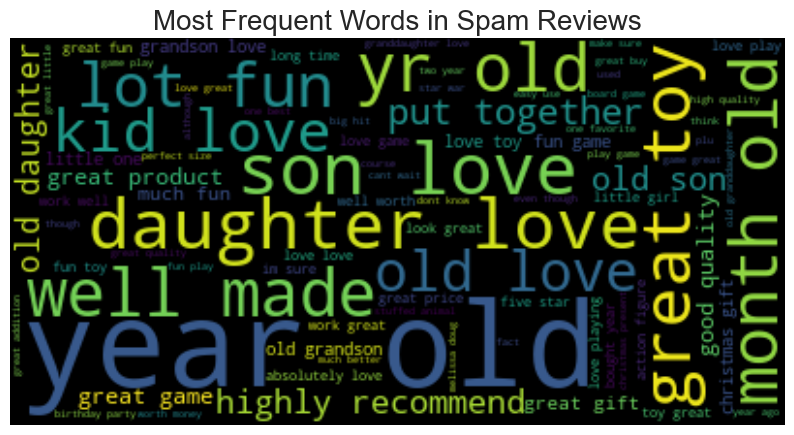

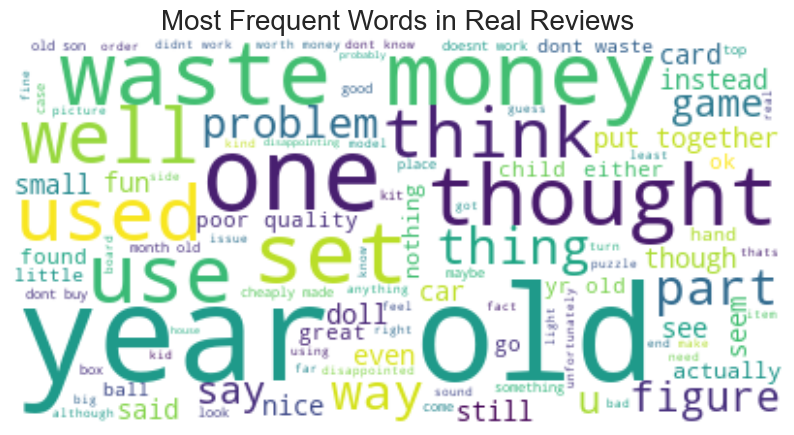

In [7]:
# Split the data into spam and real reviews
spam_text = " ".join(review for review in data[data['class'] == 1]['cleaned_text'])
real_text = " ".join(review for review in data[data['class'] == 0]['cleaned_text'])

# Word cloud for spam reviews
plt.figure(figsize=(10, 7))
wordcloud_spam = WordCloud(max_words=100, background_color="black").generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Spam Reviews", fontsize=20)
plt.show()

# Word cloud for real reviews
plt.figure(figsize=(10, 7))
wordcloud_real = WordCloud(max_words=100, background_color="white").generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Real Reviews", fontsize=20)
plt.show()


In [8]:
FILE_PATH = os.path.join(data_path, "Sports_and_Outdoors", "Sports_and_Outdoors.json")

chunk_size = 1000000

processed_chunks = []

start_time = time.time()

iterator = pd.read_json(FILE_PATH, lines = True, chunksize = chunk_size)

base_path = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_path, "data", "processed", "Sports_and_Outdoors")
file_name = "sports_and_outdoors.parquet"
full_path = os.path.join(out_dir, file_name)

if (os.path.exists(full_path)):
  print("File already exists")
else:
  print("Reading starts")

  for i, chunk in enumerate(iterator):
    print(f"Part {i} processing...")

    chunk = chunk.copy() 

    helpful_data = chunk['helpful'].apply(parse_helpful)

    chunk["helpful_votes"] = helpful_data.apply(lambda x : x[0])
    chunk["total_votes"] = helpful_data.apply(lambda x : x[1])
    chunk["helpfulness_ratio"] = (chunk["helpful_votes"] / chunk["total_votes"]) + 0000.1 # to not get 0

    chunk["full_text"] = chunk["summary"].astype(str) + " " + chunk["reviewText"].astype(str)
    chunk['cleaned_text'] = chunk['full_text'].apply(clean_text)

    final_chunk = chunk[["cleaned_text", "overall", "helpfulness_ratio", "class"]].copy()

    final_chunk.dropna(subset=['class'], inplace=True)
    # TODO
    final_chunk['class'] = final_chunk['class'].astype(int)

    processed_chunks.append(final_chunk)

  print("Processing completed")

  df = pd.concat(processed_chunks, ignore_index=True)

  end_time = time.time()

  print(f"Duration {end_time - start_time}")
  print(f"Total of {len(df)} lines processed")
  
  print("Saving data...")

  os.makedirs(out_dir, exist_ok=True)
  df.to_parquet(full_path)

  print("Data saved")

File already exists


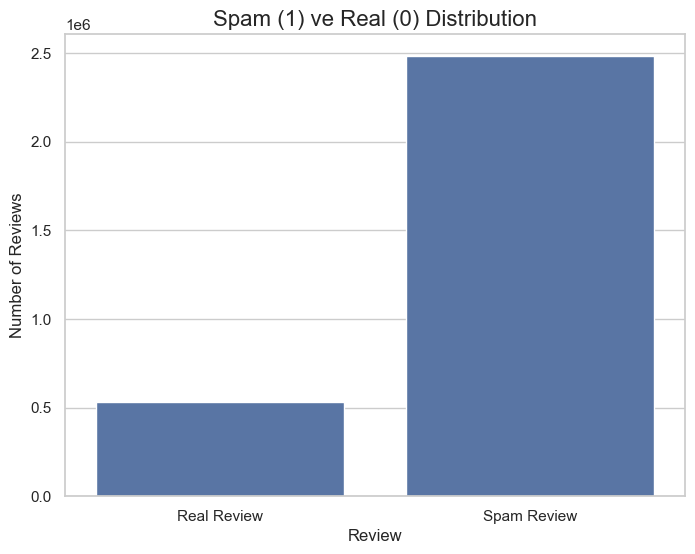

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

data = pd.read_parquet(full_path)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Spam (1) ve Real (0) Distribution', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['Real Review', 'Spam Review'])
plt.show()

C:\Users\Aybars\AppData\Local\Temp\ipykernel_21676\3284485370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=data, palette='viridis')


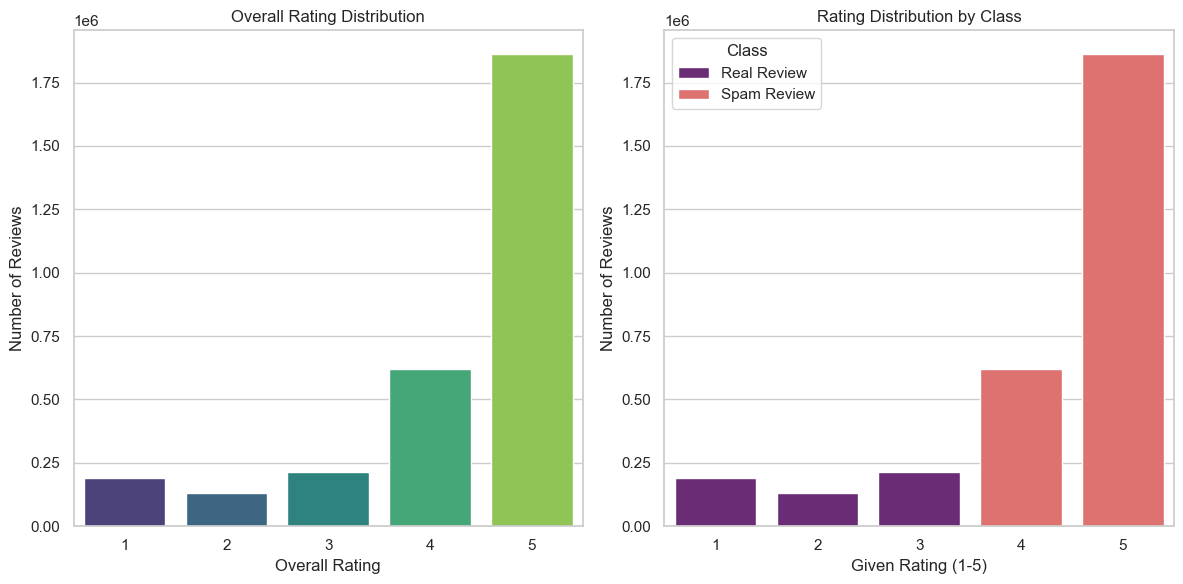

In [10]:
plt.figure(figsize=(12, 6))

# Rating distribution for all data
plt.subplot(1, 2, 1)  # 1 row, 2 columns — first plot
sns.countplot(x='overall', data=data, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

# Rating distribution by class
plt.subplot(1, 2, 2)  # 1 row, 2 columns — second plot
sns.countplot(x='overall', hue='class', data=data, palette='magma')
plt.title('Rating Distribution by Class')
plt.xlabel('Given Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.legend(title='Class', labels=['Real Review', 'Spam Review'])

plt.tight_layout()  # Adjust spacing between plots
plt.show()


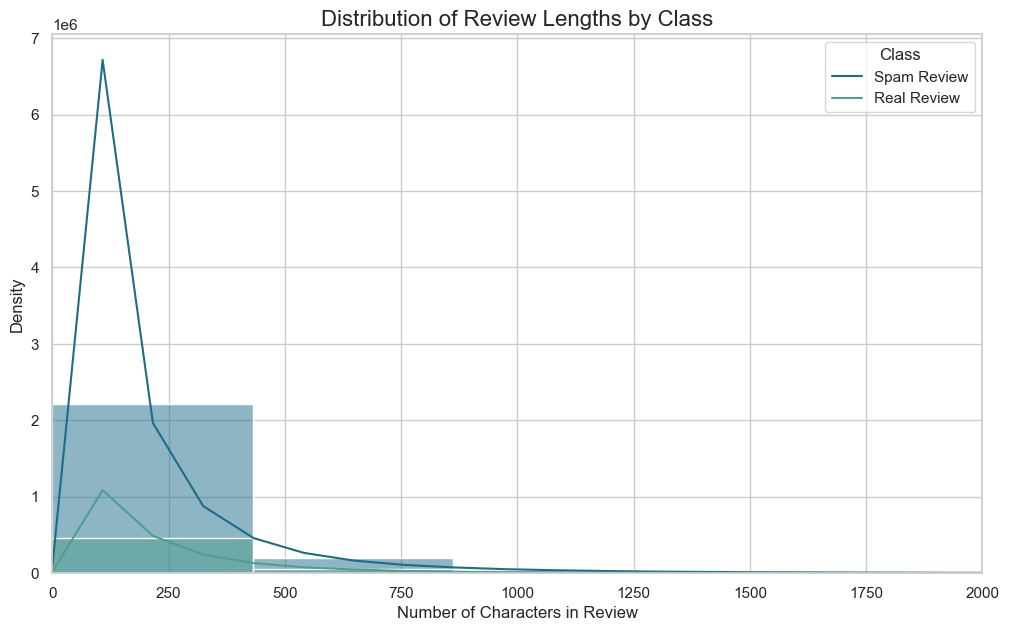

In [11]:
# Calculate the character length of the cleaned texts
data['text_length'] = data['cleaned_text'].str.len()

plt.figure(figsize=(12, 7))
sns.histplot(data=data, x='text_length', hue='class', kde=True, bins=50, palette='crest')
plt.title('Distribution of Review Lengths by Class', fontsize=16)
plt.xlabel('Number of Characters in Review', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Limit the x-axis to prevent very long reviews from distorting the plot
plt.xlim(0, 2000)
plt.legend(title='Class', labels=['Spam Review', 'Real Review'])
plt.show()


In [12]:
# # Split the data into spam and real reviews
# spam_text = " ".join(review for review in data[data['class'] == 1]['cleaned_text'])
# real_text = " ".join(review for review in data[data['class'] == 0]['cleaned_text'])

# # Word cloud for spam reviews
# plt.figure(figsize=(10, 7))
# wordcloud_spam = WordCloud(max_words=100, background_color="black").generate(spam_text)
# plt.imshow(wordcloud_spam, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Spam Reviews", fontsize=20)
# plt.show()

# # Word cloud for real reviews
# plt.figure(figsize=(10, 7))
# wordcloud_real = WordCloud(max_words=100, background_color="white").generate(real_text)
# plt.imshow(wordcloud_real, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Real Reviews", fontsize=20)
# plt.show()


In [13]:
FILE_PATH = os.path.join(data_path, "Cell_Phones_and_Accessories", "Cell_Phones_and_Accessories.json")

chunk_size = 1000000

processed_chunks = []

start_time = time.time()

iterator = pd.read_json(FILE_PATH, lines = True, chunksize = chunk_size)

base_path = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_path, "data", "processed", "Cell_Phones_and_Accessories")
file_name = "cell_phones_and_accessories.parquet"
full_path = os.path.join(out_dir, file_name)

if (os.path.exists(full_path)):
  print("File already exists")
else:
  print("Reading starts")

  for i, chunk in enumerate(iterator):
    print(f"Part {i} processing...")

    chunk = chunk.copy() 

    helpful_data = chunk['helpful'].apply(parse_helpful)

    chunk["helpful_votes"] = helpful_data.apply(lambda x : x[0])
    chunk["total_votes"] = helpful_data.apply(lambda x : x[1])
    chunk["helpfulness_ratio"] = (chunk["helpful_votes"] / chunk["total_votes"]) + 0000.1 # to not get 0

    chunk["full_text"] = chunk["summary"].astype(str) + " " + chunk["reviewText"].astype(str)
    chunk['cleaned_text'] = chunk['full_text'].apply(clean_text)

    final_chunk = chunk[["cleaned_text", "overall", "helpfulness_ratio", "class"]].copy()

    final_chunk.dropna(subset=['class'], inplace=True)
    # TODO
    final_chunk['class'] = final_chunk['class'].astype(int)

    processed_chunks.append(final_chunk)

  print("Processing completed")

  df = pd.concat(processed_chunks, ignore_index=True)

  end_time = time.time()

  print(f"Duration {end_time - start_time}")
  print(f"Total of {len(df)} lines processed")
  
  print("Saving data...")

  os.makedirs(out_dir, exist_ok=True)
  df.to_parquet(full_path)

  print("Data saved")

File already exists


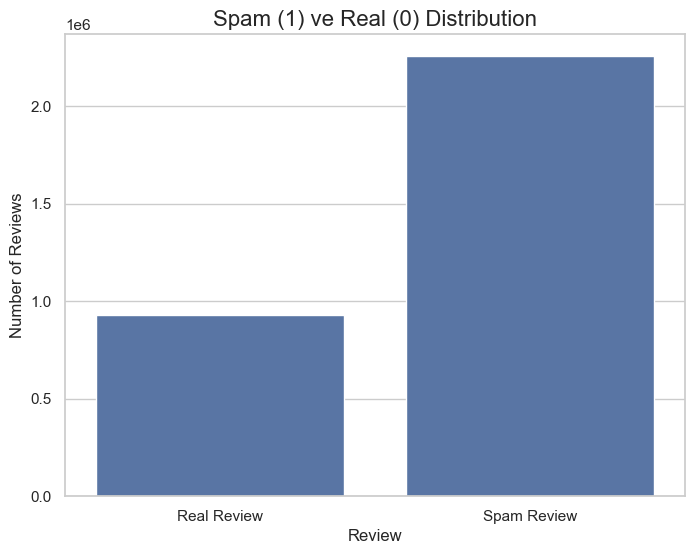

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

data = pd.read_parquet(full_path)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Spam (1) ve Real (0) Distribution', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['Real Review', 'Spam Review'])
plt.show()

C:\Users\Aybars\AppData\Local\Temp\ipykernel_21676\3284485370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=data, palette='viridis')


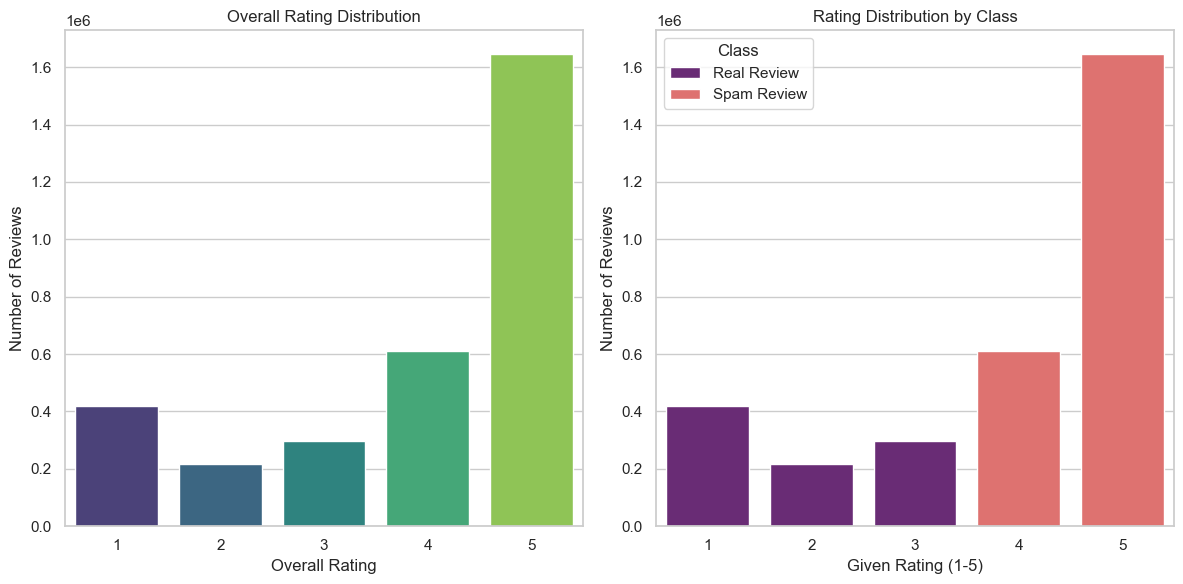

In [15]:
plt.figure(figsize=(12, 6))

# Rating distribution for all data
plt.subplot(1, 2, 1)  # 1 row, 2 columns — first plot
sns.countplot(x='overall', data=data, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

# Rating distribution by class
plt.subplot(1, 2, 2)  # 1 row, 2 columns — second plot
sns.countplot(x='overall', hue='class', data=data, palette='magma')
plt.title('Rating Distribution by Class')
plt.xlabel('Given Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.legend(title='Class', labels=['Real Review', 'Spam Review'])

plt.tight_layout()  # Adjust spacing between plots
plt.show()


In [16]:
# # Calculate the character length of the cleaned texts
# data['text_length'] = data['cleaned_text'].str.len()

# plt.figure(figsize=(12, 7))
# sns.histplot(data=data, x='text_length', hue='class', kde=True, bins=50, palette='crest')
# plt.title('Distribution of Review Lengths by Class', fontsize=16)
# plt.xlabel('Number of Characters in Review', fontsize=12)
# plt.ylabel('Density', fontsize=12)

# # Limit the x-axis to prevent very long reviews from distorting the plot
# plt.xlim(0, 2000)
# plt.legend(title='Class', labels=['Spam Review', 'Real Review'])
# plt.show()


In [17]:
# # Split the data into spam and real reviews
# spam_text = " ".join(review for review in data[data['class'] == 1]['cleaned_text'])
# real_text = " ".join(review for review in data[data['class'] == 0]['cleaned_text'])

# # Word cloud for spam reviews
# plt.figure(figsize=(10, 7))
# wordcloud_spam = WordCloud(max_words=100, background_color="black").generate(spam_text)
# plt.imshow(wordcloud_spam, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Spam Reviews", fontsize=20)
# plt.show()

# # Word cloud for real reviews
# plt.figure(figsize=(10, 7))
# wordcloud_real = WordCloud(max_words=100, background_color="white").generate(real_text)
# plt.imshow(wordcloud_real, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Real Reviews", fontsize=20)
# plt.show()


In [18]:
FILE_PATH = os.path.join(data_path, "Clothing_Shoes_and_Jewelry", "Clothing_Shoes_and_Jewelry.json")

chunk_size = 1000000

processed_chunks = []

start_time = time.time()

iterator = pd.read_json(FILE_PATH, lines = True, chunksize = chunk_size)

base_path = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_path, "data", "processed", "Clothing_Shoes_and_Jewelry")
file_name = "clothing_shoes_and_jewelry.parquet"
full_path = os.path.join(out_dir, file_name)

if (os.path.exists(full_path)):
  print("File already exists")
else:
  print("Reading starts")

  for i, chunk in enumerate(iterator):
    print(f"Part {i} processing...")

    chunk = chunk.copy() 

    helpful_data = chunk['helpful'].apply(parse_helpful)

    chunk["helpful_votes"] = helpful_data.apply(lambda x : x[0])
    chunk["total_votes"] = helpful_data.apply(lambda x : x[1])
    chunk["helpfulness_ratio"] = (chunk["helpful_votes"] / chunk["total_votes"]) + 0000.1 # to not get 0

    chunk["full_text"] = chunk["summary"].astype(str) + " " + chunk["reviewText"].astype(str)
    chunk['cleaned_text'] = chunk['full_text'].apply(clean_text)

    final_chunk = chunk[["cleaned_text", "overall", "helpfulness_ratio", "class"]].copy()

    final_chunk.dropna(subset=['class'], inplace=True)
    # TODO
    final_chunk['class'] = final_chunk['class'].astype(int)

    processed_chunks.append(final_chunk)

  print("Processing completed")

  df = pd.concat(processed_chunks, ignore_index=True)

  end_time = time.time()

  print(f"Duration {end_time - start_time}")
  print(f"Total of {len(df)} lines processed")
  
  print("Saving data...")

  os.makedirs(out_dir, exist_ok=True)
  df.to_parquet(full_path)

  print("Data saved")

File already exists


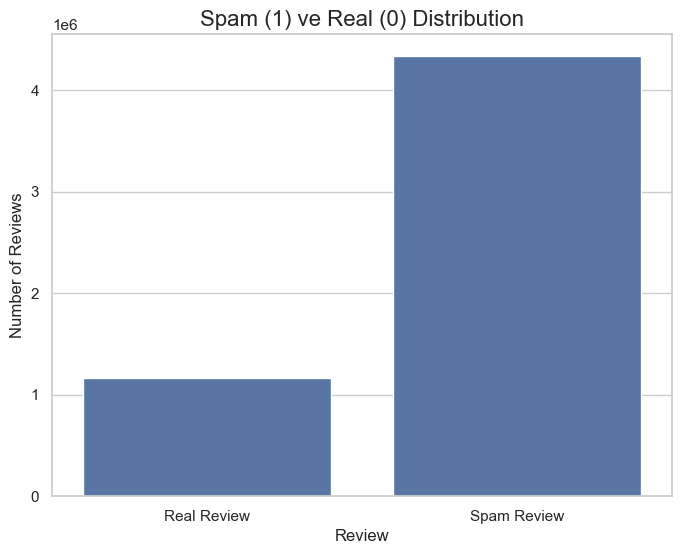

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

data = pd.read_parquet(full_path)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Spam (1) ve Real (0) Distribution', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['Real Review', 'Spam Review'])
plt.show()

C:\Users\Aybars\AppData\Local\Temp\ipykernel_21676\3284485370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=data, palette='viridis')


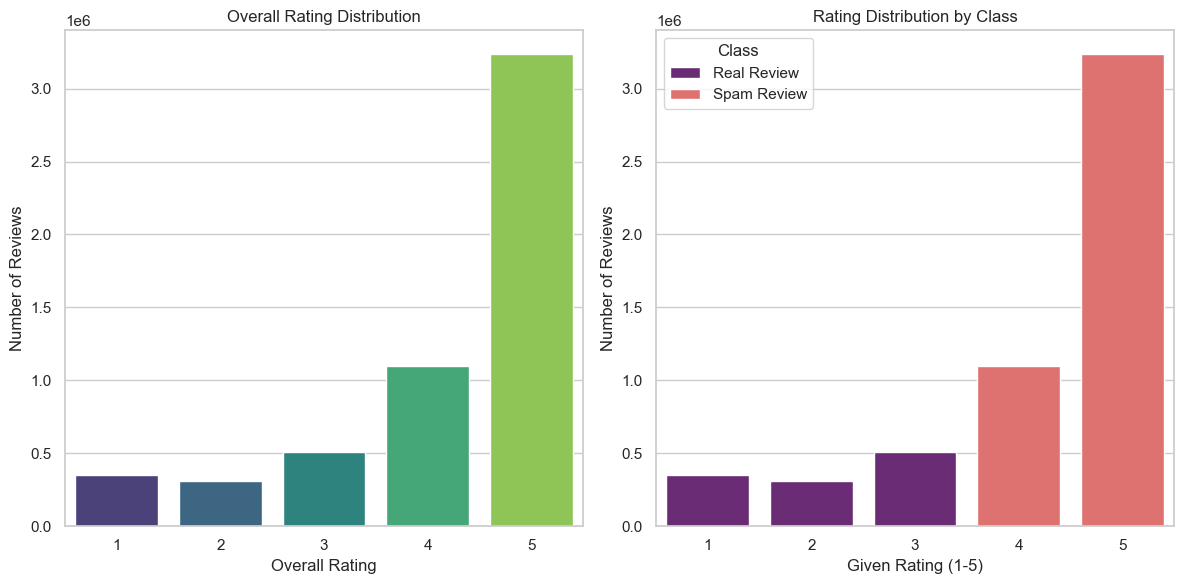

In [20]:
plt.figure(figsize=(12, 6))

# Rating distribution for all data
plt.subplot(1, 2, 1)  # 1 row, 2 columns — first plot
sns.countplot(x='overall', data=data, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

# Rating distribution by class
plt.subplot(1, 2, 2)  # 1 row, 2 columns — second plot
sns.countplot(x='overall', hue='class', data=data, palette='magma')
plt.title('Rating Distribution by Class')
plt.xlabel('Given Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.legend(title='Class', labels=['Real Review', 'Spam Review'])

plt.tight_layout()  # Adjust spacing between plots
plt.show()


In [21]:
# # Calculate the character length of the cleaned texts
# data['text_length'] = data['cleaned_text'].str.len()

# plt.figure(figsize=(12, 7))
# sns.histplot(data=data, x='text_length', hue='class', kde=True, bins=50, palette='crest')
# plt.title('Distribution of Review Lengths by Class', fontsize=16)
# plt.xlabel('Number of Characters in Review', fontsize=12)
# plt.ylabel('Density', fontsize=12)

# # Limit the x-axis to prevent very long reviews from distorting the plot
# plt.xlim(0, 2000)
# plt.legend(title='Class', labels=['Spam Review', 'Real Review'])
# plt.show()


In [22]:
# # Split the data into spam and real reviews
# spam_text = " ".join(review for review in data[data['class'] == 1]['cleaned_text'])
# real_text = " ".join(review for review in data[data['class'] == 0]['cleaned_text'])

# # Word cloud for spam reviews
# plt.figure(figsize=(10, 7))
# wordcloud_spam = WordCloud(max_words=100, background_color="black").generate(spam_text)
# plt.imshow(wordcloud_spam, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Spam Reviews", fontsize=20)
# plt.show()

# # Word cloud for real reviews
# plt.figure(figsize=(10, 7))
# wordcloud_real = WordCloud(max_words=100, background_color="white").generate(real_text)
# plt.imshow(wordcloud_real, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Real Reviews", fontsize=20)
# plt.show()


In [23]:
FILE_PATH = os.path.join(data_path, "Electronics", "Electronics.json")

chunk_size = 1000000

processed_chunks = []

start_time = time.time()

iterator = pd.read_json(FILE_PATH, lines = True, chunksize = chunk_size)

base_path = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_path, "data", "processed", "Electronics")
file_name = "electronics.parquet"
full_path = os.path.join(out_dir, file_name)

if (os.path.exists(full_path)):
  print("File already exists")
else:
  print("Reading starts")

  for i, chunk in enumerate(iterator):
    print(f"Part {i} processing...")

    chunk = chunk.copy() 

    helpful_data = chunk['helpful'].apply(parse_helpful)

    chunk["helpful_votes"] = helpful_data.apply(lambda x : x[0])
    chunk["total_votes"] = helpful_data.apply(lambda x : x[1])
    chunk["helpfulness_ratio"] = (chunk["helpful_votes"] / chunk["total_votes"]) + 0000.1 # to not get 0

    chunk["full_text"] = chunk["summary"].astype(str) + " " + chunk["reviewText"].astype(str)
    chunk['cleaned_text'] = chunk['full_text'].apply(clean_text)

    final_chunk = chunk[["cleaned_text", "overall", "helpfulness_ratio", "class"]].copy()

    final_chunk.dropna(subset=['class'], inplace=True)
    # TODO
    final_chunk['class'] = final_chunk['class'].astype(int)

    processed_chunks.append(final_chunk)

  print("Processing completed")

  df = pd.concat(processed_chunks, ignore_index=True)

  end_time = time.time()

  print(f"Duration {end_time - start_time}")
  print(f"Total of {len(df)} lines processed")
  
  print("Saving data...")

  os.makedirs(out_dir, exist_ok=True)
  df.to_parquet(full_path)

  print("Data saved")

File already exists


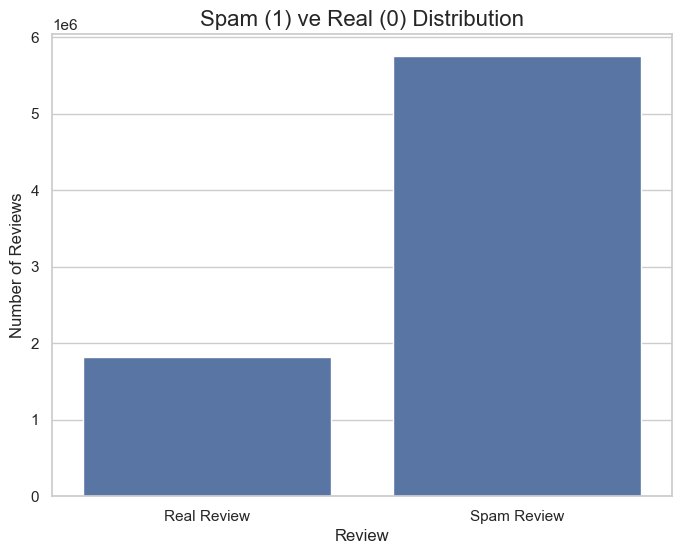

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

data = pd.read_parquet(full_path)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Spam (1) ve Real (0) Distribution', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['Real Review', 'Spam Review'])
plt.show()

C:\Users\Aybars\AppData\Local\Temp\ipykernel_21676\3284485370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=data, palette='viridis')


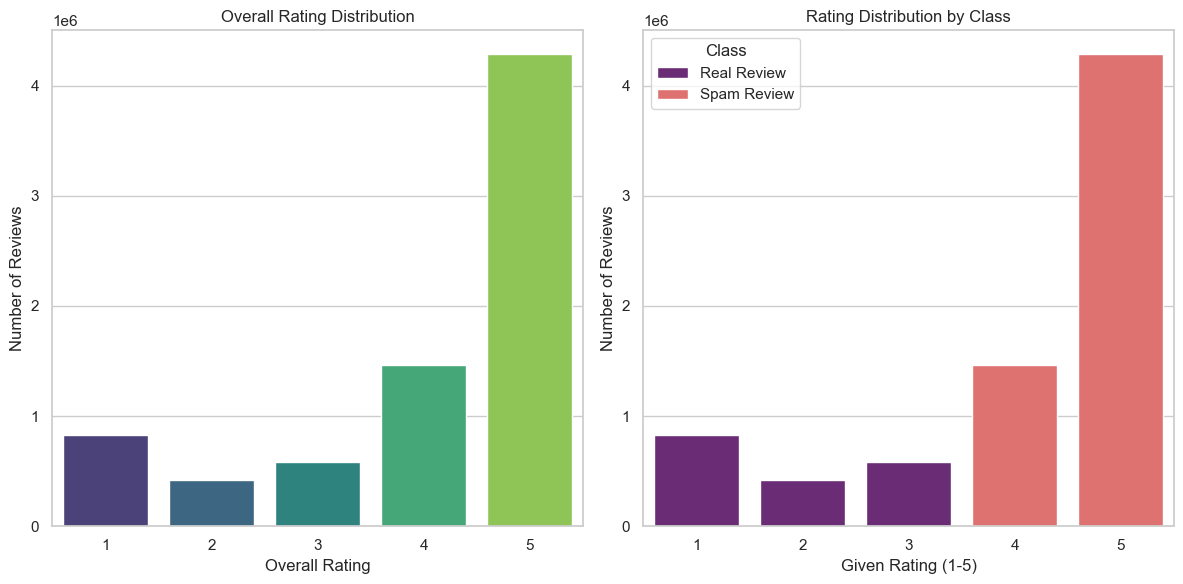

In [25]:
plt.figure(figsize=(12, 6))

# Rating distribution for all data
plt.subplot(1, 2, 1)  # 1 row, 2 columns — first plot
sns.countplot(x='overall', data=data, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

# Rating distribution by class
plt.subplot(1, 2, 2)  # 1 row, 2 columns — second plot
sns.countplot(x='overall', hue='class', data=data, palette='magma')
plt.title('Rating Distribution by Class')
plt.xlabel('Given Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.legend(title='Class', labels=['Real Review', 'Spam Review'])

plt.tight_layout()  # Adjust spacing between plots
plt.show()


In [26]:
# # Calculate the character length of the cleaned texts
# data['text_length'] = data['cleaned_text'].str.len()

# plt.figure(figsize=(12, 7))
# sns.histplot(data=data, x='text_length', hue='class', kde=True, bins=50, palette='crest')
# plt.title('Distribution of Review Lengths by Class', fontsize=16)
# plt.xlabel('Number of Characters in Review', fontsize=12)
# plt.ylabel('Density', fontsize=12)

# # Limit the x-axis to prevent very long reviews from distorting the plot
# plt.xlim(0, 2000)
# plt.legend(title='Class', labels=['Spam Review', 'Real Review'])
# plt.show()


In [27]:
# # Split the data into spam and real reviews
# spam_text = " ".join(review for review in data[data['class'] == 1]['cleaned_text'])
# real_text = " ".join(review for review in data[data['class'] == 0]['cleaned_text'])

# # Word cloud for spam reviews
# plt.figure(figsize=(10, 7))
# wordcloud_spam = WordCloud(max_words=100, background_color="black").generate(spam_text)
# plt.imshow(wordcloud_spam, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Spam Reviews", fontsize=20)
# plt.show()

# # Word cloud for real reviews
# plt.figure(figsize=(10, 7))
# wordcloud_real = WordCloud(max_words=100, background_color="white").generate(real_text)
# plt.imshow(wordcloud_real, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Real Reviews", fontsize=20)
# plt.show()


In [28]:
FILE_PATH = os.path.join(data_path, "Home_and_Kitchen", "Home_and_Kitchen.json")

chunk_size = 1000000

processed_chunks = []

start_time = time.time()

iterator = pd.read_json(FILE_PATH, lines = True, chunksize = chunk_size)

base_path = os.path.dirname(os.getcwd())
out_dir = os.path.join(base_path, "data", "processed", "Home_and_Kitchen")
file_name = "home_and_kitchen.parquet"
full_path = os.path.join(out_dir, file_name)

if (os.path.exists(full_path)):
  print("File already exists")
else:
  print("Reading starts")

  for i, chunk in enumerate(iterator):
    print(f"Part {i} processing...")

    chunk = chunk.copy() 

    helpful_data = chunk['helpful'].apply(parse_helpful)

    chunk["helpful_votes"] = helpful_data.apply(lambda x : x[0])
    chunk["total_votes"] = helpful_data.apply(lambda x : x[1])
    chunk["helpfulness_ratio"] = (chunk["helpful_votes"] / chunk["total_votes"]) + 0000.1 # to not get 0

    chunk["full_text"] = chunk["summary"].astype(str) + " " + chunk["reviewText"].astype(str)
    chunk['cleaned_text'] = chunk['full_text'].apply(clean_text)

    final_chunk = chunk[["cleaned_text", "overall", "helpfulness_ratio", "class"]].copy()

    final_chunk.dropna(subset=['class'], inplace=True)
    # TODO
    final_chunk['class'] = final_chunk['class'].astype(int)

    processed_chunks.append(final_chunk)

  print("Processing completed")

  df = pd.concat(processed_chunks, ignore_index=True)

  end_time = time.time()

  print(f"Duration {end_time - start_time}")
  print(f"Total of {len(df)} lines processed")
  
  print("Saving data...")

  os.makedirs(out_dir, exist_ok=True)
  df.to_parquet(full_path)

  print("Data saved")

File already exists


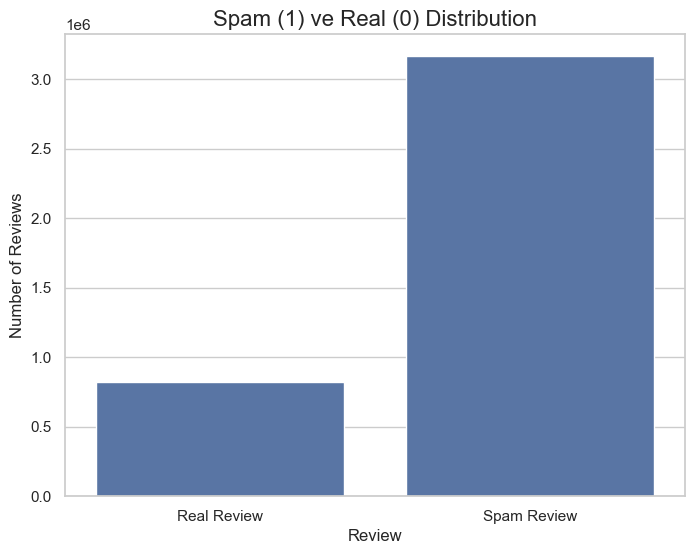

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

data = pd.read_parquet(full_path)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Spam (1) ve Real (0) Distribution', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['Real Review', 'Spam Review'])
plt.show()

C:\Users\Aybars\AppData\Local\Temp\ipykernel_21676\3284485370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=data, palette='viridis')


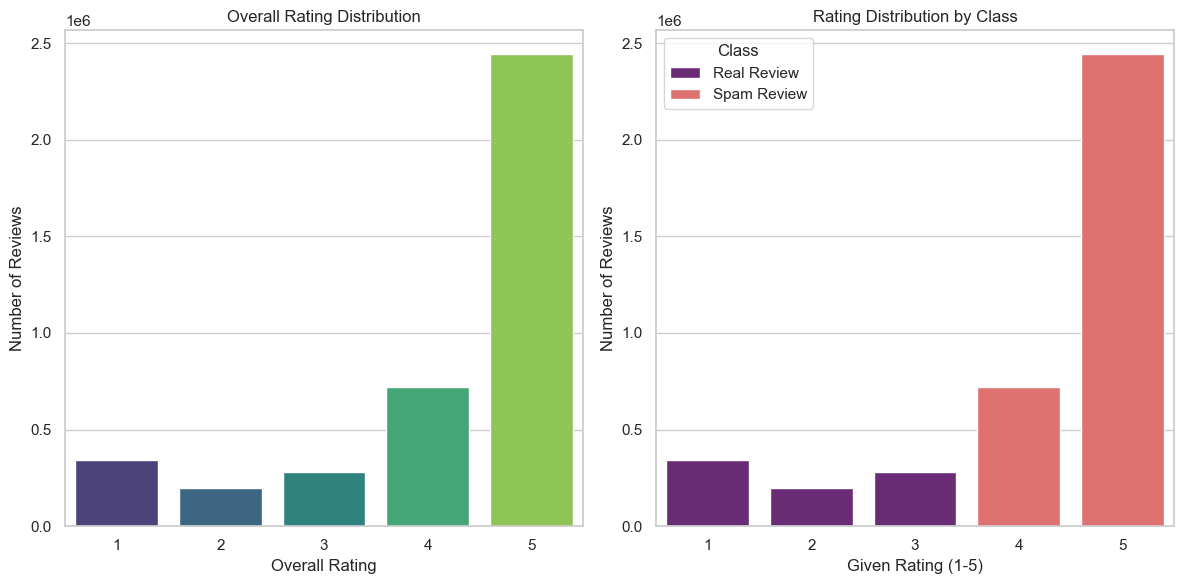

In [30]:
plt.figure(figsize=(12, 6))

# Rating distribution for all data
plt.subplot(1, 2, 1)  # 1 row, 2 columns — first plot
sns.countplot(x='overall', data=data, palette='viridis')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

# Rating distribution by class
plt.subplot(1, 2, 2)  # 1 row, 2 columns — second plot
sns.countplot(x='overall', hue='class', data=data, palette='magma')
plt.title('Rating Distribution by Class')
plt.xlabel('Given Rating (1-5)')
plt.ylabel('Number of Reviews')
plt.legend(title='Class', labels=['Real Review', 'Spam Review'])

plt.tight_layout()  # Adjust spacing between plots
plt.show()


In [31]:
# # Calculate the character length of the cleaned texts
# data['text_length'] = data['cleaned_text'].str.len()

# plt.figure(figsize=(12, 7))
# sns.histplot(data=data, x='text_length', hue='class', kde=True, bins=50, palette='crest')
# plt.title('Distribution of Review Lengths by Class', fontsize=16)
# plt.xlabel('Number of Characters in Review', fontsize=12)
# plt.ylabel('Density', fontsize=12)

# # Limit the x-axis to prevent very long reviews from distorting the plot
# plt.xlim(0, 2000)
# plt.legend(title='Class', labels=['Spam Review', 'Real Review'])
# plt.show()


In [32]:
# # Split the data into spam and real reviews
# spam_text = " ".join(review for review in data[data['class'] == 1]['cleaned_text'])
# real_text = " ".join(review for review in data[data['class'] == 0]['cleaned_text'])

# # Word cloud for spam reviews
# plt.figure(figsize=(10, 7))
# wordcloud_spam = WordCloud(max_words=100, background_color="black").generate(spam_text)
# plt.imshow(wordcloud_spam, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Spam Reviews", fontsize=20)
# plt.show()

# # Word cloud for real reviews
# plt.figure(figsize=(10, 7))
# wordcloud_real = WordCloud(max_words=100, background_color="white").generate(real_text)
# plt.imshow(wordcloud_real, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most Frequent Words in Real Reviews", fontsize=20)
# plt.show()
